In [1]:
from __future__ import print_function

import argparse
import gzip
import json
import os
import pickle

import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)


def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels


def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 28, 28, 1)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 28, 28, 1)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 28, 28, 1)
    train_y = train_y.astype('int32')
    print('... done loading data')
    return train_x, train_y, valid_x, valid_y, test_x, test_y

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

def cnn_network(features,labels,mode):
    # Convolutional Layer #1
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    conv1 = tf.layers.conv2d(
              inputs=input_layer,
              filters=16,
              kernel_size=[7, 7],
              padding="same",
              activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    # Convolutional Layer #1
    conv2 = tf.layers.conv2d(
              inputs=pool1,
              filters=16,
              kernel_size=[7, 7],
              padding="same",
              activation=tf.nn.relu)

    # Pooling Layer #1
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        
    # Dense Layer
    #np.ravel(np.copy(pool2)) #    
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 16])
    dense = tf.layers.dense(inputs=pool2_flat, units=128, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4,training=True)#size: [batch_size,128]#, training=mode == tf.estimator.ModeKeys.TRAIN)
            
    # Logits Layer        
    logits = tf.layers.dense(inputs=dropout, units=10)#size: [batch_size,10]  
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
     "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the `logging_hook`.
     "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
       }
    #if mode == tf.estimator.ModeKeys.PREDICT:
       # return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
        
    # Calculate Loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
      
    if mode == tf.estimator.ModeKeys.TRAIN:
        print("in training mode............")
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
   
        train_op  = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        estimator  = tf.estimator.EstimatorSpec(tf.estimator.ModeKeys.TRAIN,loss=loss, train_op=train_op)
        return estimator
    
    # Add evaluation metrics (for EVAL mode)
    if mode == tf.estimator.ModeKeys.EVAL: 
        print("in validation mode............")
        eval_metric_ops = { "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
    
   
    
def train_and_validate(x_train, y_train, x_valid, y_valid, num_epochs, lr, num_filters, batch_size):
    # TODO: train and validate your convolutional neural networks with the provided data and hyperparameters
    #cnn_network(x_train,y_train,lr, num_filters)
    #print(np.shape(x_train))
    #print(np.shape(y_train))
    #print("y train labels::",y_train)
    #print("y train labels::")
    
    # Set up logging for predictions
    tensors_to_log = {"probabilities": "softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=20)
    
    # Create the Estimator
    mnist_classifier = tf.estimator.Estimator(model_fn=cnn_network, model_dir="./mnist_convnet_modellearningrate1-1x1")
    
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn( x={"x": x_train},    y=y_train,    batch_size=batch_size,   
                                                        num_epochs=None,    shuffle=True)
    
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(    x={"x": x_valid},  y=y_valid,  num_epochs=1, shuffle=False)
        
    learning_curve=[]
    
    for i in range(1,num_epochs):
        train_results = mnist_classifier.train( input_fn = train_input_fn,  hooks=[logging_hook],steps=1)
        print("training results")
        print(train_results)


        eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
        print("eval results")
        print(eval_results)
        learning_curve.append(eval_results)
    
    return learning_curve,mnist_classifier  # TODO: Return the validation error after each epoch (i.e learning curve) and your model


def test(x_test, y_test, model):
    # TODO: test your network here by evaluating it on the test data
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(    x={"x": x_test},  y=y_test,  num_epochs=1, shuffle=False)
    
    test_results = model.evaluate(input_fn=eval_input_fn)
    
    return test_results


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--output_path", default="./", type=str, nargs="?",
                        help="Path where the results will be stored")
    parser.add_argument("--input_path", default="./", type=str, nargs="?",
                        help="Path where the data is located. If the data is not available it will be downloaded first")
    parser.add_argument("--learning_rate", default=1e-3, type=float, nargs="?", help="Learning rate for SGD")
    parser.add_argument("--num_filters", default=32, type=int, nargs="?",
                        help="The number of filters for each convolution layer")
    parser.add_argument("--batch_size", default=128, type=int, nargs="?", help="Batch size for SGD")
    parser.add_argument("--epochs", default=12, type=int, nargs="?",
                        help="Determines how many epochs the network will be trained")
    parser.add_argument("--run_id", default=0, type=int, nargs="?",
                        help="Helps to identify different runs of an experiments")

    #args = parser.parse_args()

    # hyperparameters
    lr = [0.1,0.01,0.001,0.0001] #args.learning_rate
    def get_learning_rates():
        return lr
    
    num_filters = 16 #args.num_filters
    batch_size = 128 #args.batch_size
    epochs = 400 #args.epochs

    # train and test convolutional neural network
    x_train, y_train, x_valid, y_valid, x_test, y_test = mnist("./")#args.input_path)

    
    learning_curve, model =  train_and_validate(x_train, y_train, x_valid, y_valid, epochs, lr, num_filters, batch_size)
    test_error = test(x_test, y_test, model)
    print("test results:",test_error)
       

    # save results in a dictionary and write them into a .json file
    results = dict()
    results["lr"] = lr
    results["num_filters"] = num_filters
    results["batch_size"] = batch_size
    results["learning_curve"] = learning_curve
    results["test_error"] = test_error

    path = os.path.join("./", "results")#args.output_path
    os.makedirs(path, exist_ok=True)

    fname = os.path.join(path, "results_run_%d.json" )#% args.run_id)

    fh = open(fname, "w")
    #json.dump(results, fh)
    fh.close()


C:\Users\MYPC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


... loading data
... done loading data
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './mnist_convnet_modellearningrate1-1x1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001BCFB81CF98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` m

INFO:tensorflow:loss = 2.2759006, step = 4
INFO:tensorflow:Saving checkpoints for 4 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 2.2759006.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:48:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-4
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:48:40
INFO:tensorflow:Saving dict for global step 4: accuracy = 0.1617, global_step = 4, loss = 2.2761714
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-4
eval results
{'accuracy': 0.1617, 'loss': 2.2761714, 'global_step': 4}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-8
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:49:03
INFO:tensorflow:Saving dict for global step 8: accuracy = 0.2526, global_step = 8, loss = 2.2243881
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-8
eval results
{'accuracy': 0.2526, 'loss': 2.2243881, 'global_step': 8}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-8
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8 into ./mnist_convnet_modellearningr

eval results
{'accuracy': 0.3558, 'loss': 2.14247, 'global_step': 12}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-12
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 12 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.10078714 0.07425063 0.11822094 ... 0.09808618 0.11810428 0.08960489]
 [0.09543297 0.11873704 0.09867997 ... 0.13854447 0.08499271 0.09651371]
 [0.11124036 0.10217078 0.10884029 ... 0.13529341 0.09438073 0.06936707]
 ...
 [0.16210447 0.06444049 0.12994929 ... 0.08171382 0.0789676  0.07950065]
 [0.08933967 0.11918522 0.07537518 ... 0.13279796 0.11121873 0.08489647]
 [0.10416227 0.08868333 0.09392189 ... 0.08488208 0.13643807 0.078745

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 16 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.13078582 0.06605547 0.19669074 ... 0.03783189 0.06423847 0.15314227]
 [0.18575512 0.07074257 0.11468046 ... 0.13203633 0.11378673 0.07800572]
 [0.06712758 0.10137413 0.11526491 ... 0.11448828 0.09143029 0.08095755]
 ...
 [0.10697687 0.09283893 0.12053563 ... 0.09536267 0.0850025  0.08935028]
 [0.2028586  0.05875334 0.13272116 ... 0.04937103 0.09179483 0.11698867]
 [0.12745288 0.13228883 0.10535029 ... 0.12770754 0.07916871 0.09510028]]
INFO:tensorflow:loss = 2.0331297, step = 17
INFO:tensorflow:Saving checkpoints for 17 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 2.0331297.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:49:49
INFO:tensorf

INFO:tensorflow:loss = 1.8784506, step = 21
INFO:tensorflow:Saving checkpoints for 21 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 1.8784506.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:50:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-21
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:50:15
INFO:tensorflow:Saving dict for global step 21: accuracy = 0.4766, global_step = 21, loss = 1.7760518
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-21
eval results
{'accuracy': 0.4766, 'loss': 1.7760518, 'global_step': 21}
INFO:tensorflow:Calling model_fn.
in training mode..........

INFO:tensorflow:Starting evaluation at 2018-11-09-21:50:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-25
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:50:37
INFO:tensorflow:Saving dict for global step 25: accuracy = 0.5005, global_step = 25, loss = 1.6846526
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 25: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-25
eval results
{'accuracy': 0.5005, 'loss': 1.6846526, 'global_step': 25}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-25
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tenso

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 29: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-29
eval results
{'accuracy': 0.5353, 'loss': 1.3439577, 'global_step': 29}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-29
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 29 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.08193242 0.02982541 0.6193445  ... 0.00159146 0.00881516 0.01164761]
 [0.08207137 0.03458168 0.19641182 ... 0.01013494 0.01457452 0.05509759]
 [0.02244459 0.00325154 0.09582229 ... 0.00216543 0.00283695 0.02550469]
 ...
 [0.01960556 0.02375842 0.01184739 ... 0.37427166 0.07345816 0.39228597]
 [0.05885074 0.110

INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-33
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 33 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00230673 0.604048   0.11742746 ... 0.02173644 0.20757782 0.00209984]
 [0.00483839 0.08353104 0.00163225 ... 0.2237462  0.57890064 0.02183747]
 [0.184324   0.0003382  0.01869285 ... 0.00608775 0.05540814 0.00037281]
 ...
 [0.22477464 0.00059242 0.00339162 ... 0.00684167 0.26286796 0.00808532]
 [0.03162999 0.02357714 0.04061274 ... 0.02876192 0.11748804 0.10947248]
 [0.03034361 0.00090123 0.03708076 ... 0.01197113 0.01501814 0.04364646]]
INFO:tensorflow:loss = 1.3793666, step = 34
INFO:tensorflow:Saving checkpoints for 34 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 1.3793666.
training results
INFO:tensorflow:Calling model_fn.
in vali

INFO:tensorflow:loss = 0.92338693, step = 38
INFO:tensorflow:Saving checkpoints for 38 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.92338693.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:51:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-38
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:51:49
INFO:tensorflow:Saving dict for global step 38: accuracy = 0.7214, global_step = 38, loss = 0.8901722
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 38: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-38
eval results
{'accuracy': 0.7214, 'loss': 0.8901722, 'global_step': 38}
INFO:tensorflow:Calling model_fn.
in training mode........

INFO:tensorflow:Starting evaluation at 2018-11-09-21:52:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-42
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:52:11
INFO:tensorflow:Saving dict for global step 42: accuracy = 0.7584, global_step = 42, loss = 0.78230584
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 42: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-42
eval results
{'accuracy': 0.7584, 'loss': 0.78230584, 'global_step': 42}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-42
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:ten

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 46: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-46
eval results
{'accuracy': 0.7105, 'loss': 0.87366194, 'global_step': 46}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-46
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 46 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00099756 0.00091087 0.00106085 ... 0.94954765 0.00384602 0.04235719]
 [0.02182986 0.00391565 0.01932831 ... 0.01573547 0.0711935  0.57458407]
 [0.96541405 0.0000078  0.00191959 ... 0.00019916 0.00516314 0.00022024]
 ...
 [0.00138638 0.01388656 0.00175217 ... 0.92654604 0.01081941 0.03296611]
 [0.00251627 0.48

INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.12289347 0.00315708 0.04557673 ... 0.01472469 0.08281158 0.05247216]
 [0.2769748  0.00036279 0.10899619 ... 0.00452914 0.00881298 0.00153084]
 [0.01029992 0.01682255 0.00392901 ... 0.8796333  0.01700058 0.03009007]
 ...
 [0.03325735 0.00506905 0.01071802 ... 0.00063383 0.00682865 0.00444651]
 [0.01188746 0.00296118 0.16625544 ... 0.01284428 0.13369493 0.00568165]
 [0.8239088  0.00002429 0.04802391 ... 0.00274651 0.02122584 0.0010773 ]]
INFO:tensorflow:loss = 0.77680165, step = 51
INFO:tensorflow:Saving checkpoints for 51 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.77680165.
training results
INFO:tensorflow:Calling model_fn.
in va

INFO:tensorflow:loss = 0.7967537, step = 55
INFO:tensorflow:Saving checkpoints for 55 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.7967537.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:53:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-55
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:53:23
INFO:tensorflow:Saving dict for global step 55: accuracy = 0.7987, global_step = 55, loss = 0.64376694
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 55: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-55
eval results
{'accuracy': 0.7987, 'loss': 0.64376694, 'global_step': 55}
INFO:tensorflow:Calling model_fn.
in training mode........

INFO:tensorflow:Starting evaluation at 2018-11-09-21:53:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-59
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:53:46
INFO:tensorflow:Saving dict for global step 59: accuracy = 0.836, global_step = 59, loss = 0.5410284
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 59: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-59
eval results
{'accuracy': 0.836, 'loss': 0.5410284, 'global_step': 59}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-59
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorf

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 63: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-63
eval results
{'accuracy': 0.818, 'loss': 0.58854926, 'global_step': 63}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-63
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 63 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00003448 0.92556036 0.00059705 ... 0.04954714 0.00769404 0.00998901]
 [0.28117228 0.04134036 0.08960138 ... 0.00969334 0.02950424 0.00903765]
 [0.01608188 0.00687236 0.01071791 ... 0.00247171 0.00779674 0.18795505]
 ...
 [0.00608104 0.00904549 0.02742069 ... 0.07385553 0.73895895 0.02707585]
 [0.05674431 0.000

INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-67
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 67 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.0018087  0.6347404  0.09921966 ... 0.05130133 0.08101048 0.03723585]
 [0.0004386  0.09131242 0.00094728 ... 0.7261475  0.05523824 0.11524372]
 [0.01922503 0.02454576 0.06327445 ... 0.00331442 0.09756242 0.2399715 ]
 ...
 [0.05670398 0.00079072 0.05575624 ... 0.00181329 0.12369577 0.00470941]
 [0.00112582 0.0000113  0.00001321 ... 0.99178255 0.00056685 0.00506548]
 [0.130434   0.00513148 0.00371175 ... 0.10507639 0.19499822 0.02258591]]
INFO:tensorflow:loss = 0.7973994, step = 68
INFO:tensorflow:Saving checkpoints for 68 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.7973994.
training results
INFO:tensorflow:Calling model_fn.
in vali

INFO:tensorflow:loss = 0.6777495, step = 72
INFO:tensorflow:Saving checkpoints for 72 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.6777495.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:54:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-72
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:55:02
INFO:tensorflow:Saving dict for global step 72: accuracy = 0.8023, global_step = 72, loss = 0.61483395
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 72: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-72
eval results
{'accuracy': 0.8023, 'loss': 0.61483395, 'global_step': 72}
INFO:tensorflow:Calling model_fn.
in training mode........

INFO:tensorflow:Starting evaluation at 2018-11-09-21:55:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-76
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:55:24
INFO:tensorflow:Saving dict for global step 76: accuracy = 0.8556, global_step = 76, loss = 0.47802904
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 76: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-76
eval results
{'accuracy': 0.8556, 'loss': 0.47802904, 'global_step': 76}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-76
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:ten

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 80: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-80
eval results
{'accuracy': 0.8733, 'loss': 0.41731107, 'global_step': 80}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-80
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 80 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.01470288 0.00017062 0.00756613 ... 0.00005822 0.10840096 0.00366077]
 [0.0045143  0.00163166 0.811814   ... 0.00523141 0.07271165 0.00488125]
 [0.00000536 0.00157965 0.00000505 ... 0.98747385 0.00057339 0.01014944]
 ...
 [0.00913284 0.00006682 0.02430169 ... 0.00111557 0.11729869 0.01721287]
 [0.00595137 0.00

INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-84
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 84 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00067699 0.88940024 0.00041466 ... 0.06121229 0.01213421 0.01131061]
 [0.00025663 0.00030934 0.00059218 ... 0.00247843 0.00178336 0.25922617]
 [0.00003314 0.03595031 0.00089157 ... 0.83930665 0.00874705 0.11299977]
 ...
 [0.0000902  0.09980933 0.01950484 ... 0.00231089 0.00059373 0.00133188]
 [0.00037562 0.93091697 0.00031414 ... 0.01140807 0.00683681 0.0008709 ]
 [0.0000004  0.00000241 0.00000032 ... 0.0000143  0.00023088 0.00638392]]
INFO:tensorflow:loss = 0.5892999, step = 85
INFO:tensorflow:Saving checkpoints for 85 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.5892999.
training results
INFO:tensorflow:Calling model_fn.
in vali

INFO:tensorflow:loss = 0.4420051, step = 89
INFO:tensorflow:Saving checkpoints for 89 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.4420051.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:56:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-89
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:56:36
INFO:tensorflow:Saving dict for global step 89: accuracy = 0.8802, global_step = 89, loss = 0.38112044
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 89: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-89
eval results
{'accuracy': 0.8802, 'loss': 0.38112044, 'global_step': 89}
INFO:tensorflow:Calling model_fn.
in training mode........

INFO:tensorflow:Starting evaluation at 2018-11-09-21:56:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-93
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:56:58
INFO:tensorflow:Saving dict for global step 93: accuracy = 0.8857, global_step = 93, loss = 0.3808583
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 93: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-93
eval results
{'accuracy': 0.8857, 'loss': 0.3808583, 'global_step': 93}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-93
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tenso

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 97: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-97
eval results
{'accuracy': 0.8909, 'loss': 0.35791728, 'global_step': 97}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-97
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 97 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00026711 0.00030965 0.97411376 ... 0.00163104 0.00274393 0.00058576]
 [0.00005628 0.00001128 0.0001538  ... 0.00085791 0.14360715 0.02073788]
 [0.00000005 0.00000402 0.99994135 ... 0.00000135 0.00000039 0.00000033]
 ...
 [0.00000004 0.00000019 0.9999554  ... 0.00000005 0.00000026 0.0000016 ]
 [0.00070308 0.00

INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-101
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 101 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00423166 0.00649631 0.00252101 ... 0.00576357 0.05246183 0.5025213 ]
 [0.00112677 0.00180263 0.00873245 ... 0.03854404 0.03553435 0.44596162]
 [0.00037675 0.00000606 0.0000015  ... 0.9116061  0.00007548 0.08757103]
 ...
 [0.0000346  0.0000001  0.00076411 ... 0.00000001 0.00032317 0.00001204]
 [0.001136   0.00056103 0.01378857 ... 0.00015356 0.0015494  0.0000566 ]
 [0.00624531 0.00029131 0.01483856 ... 0.00262378 0.772637   0.02953961]]
INFO:tensorflow:loss = 0.30261874, step = 102
INFO:tensorflow:Saving checkpoints for 102 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.30261874.
training results
INFO:tensorflow:Calling model_fn.
i

INFO:tensorflow:loss = 0.49466127, step = 106
INFO:tensorflow:Saving checkpoints for 106 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.49466127.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:58:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-106
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:58:10
INFO:tensorflow:Saving dict for global step 106: accuracy = 0.8968, global_step = 106, loss = 0.34139627
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 106: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-106
eval results
{'accuracy': 0.8968, 'loss': 0.34139627, 'global_step': 106}
INFO:tensorflow:Calling model_fn.
in training mo

INFO:tensorflow:Starting evaluation at 2018-11-09-21:58:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-110
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-21:58:32
INFO:tensorflow:Saving dict for global step 110: accuracy = 0.9051, global_step = 110, loss = 0.33570495
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 110: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-110
eval results
{'accuracy': 0.9051, 'loss': 0.33570495, 'global_step': 110}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-110
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I

INFO:tensorflow:Saving dict for global step 114: accuracy = 0.9049, global_step = 114, loss = 0.31607583
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 114: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-114
eval results
{'accuracy': 0.9049, 'loss': 0.31607583, 'global_step': 114}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-114
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 114 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.9995171  0.         0.00000118 ... 0.         0.00000009 0.00000038]
 [0.00000595 0.00000029 0.00000937 ... 0.00000089 0.0000134  0.00000058]
 [0.00277145 0.02231716 0.0816194  ... 0.00217286 0.740451

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-118
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 118 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00073295 0.00003857 0.89555955 ... 0.04369884 0.00214046 0.0000785 ]
 [0.00160323 0.00000234 0.01619929 ... 0.00001117 0.00002541 0.00001948]
 [0.00000981 0.00277789 0.9816409  ... 0.00299545 0.0002309  0.00030509]
 ...
 [0.00000461 0.00000423 0.00003865 ... 0.00000164 0.0004949  0.00008133]
 [0.95974904 0.00000059 0.00003491 ... 0.00078567 0.00003563 0.00005989]
 [0.67305535 0.00000001 0.00011332 ... 0.00000002 0.0000126  0.00000015]]
INFO:tensorflow:loss = 0.3430031, step = 119
INFO:tensorflow:Saving checkpoints for 119 into ./mn

INFO:tensorflow:Saving checkpoints for 122 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00011377 0.97126174 0.01220158 ... 0.00405162 0.00972431 0.00129585]
 [0.00157585 0.88403153 0.02217393 ... 0.02932096 0.00874856 0.0106557 ]
 [0.00001202 0.00003706 0.00000635 ... 0.98205435 0.00163145 0.01608941]
 ...
 [0.00046577 0.00001472 0.00263699 ... 0.00103715 0.08328982 0.01261998]
 [0.00482233 0.00100669 0.00053008 ... 0.00062037 0.97482705 0.00661172]
 [0.00503122 0.00627767 0.00472105 ... 0.00854398 0.0124707  0.05114032]]
INFO:tensorflow:loss = 0.28452352, step = 123
INFO:tensorflow:Saving checkpoints for 123 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.28452352.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-21:59:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:loss = 0.2844599, step = 127
INFO:tensorflow:Saving checkpoints for 127 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.2844599.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:00:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-127
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:00:06
INFO:tensorflow:Saving dict for global step 127: accuracy = 0.9082, global_step = 127, loss = 0.29906482
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 127: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-127
eval results
{'accuracy': 0.9082, 'loss': 0.29906482, 'global_step': 127}
INFO:tensorflow:Calling model_fn.
in training mode

in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:00:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-131
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:00:27
INFO:tensorflow:Saving dict for global step 131: accuracy = 0.9137, global_step = 131, loss = 0.29395053
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 131: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-131
eval results
{'accuracy': 0.9137, 'loss': 0.29395053, 'global_step': 131}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-131
INFO:tensorflo

INFO:tensorflow:Finished evaluation at 2018-11-09-22:00:49
INFO:tensorflow:Saving dict for global step 135: accuracy = 0.9207, global_step = 135, loss = 0.26293042
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 135: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-135
eval results
{'accuracy': 0.9207, 'loss': 0.26293042, 'global_step': 135}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-135
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 135 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00921063 0.00040733 0.02888293 ... 0.0002043  0.0462102  0.00016736]
 [0.00002498 0.00005176 0.00003854 ... 0.8600547  0.00010131 0.13930182]

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-139
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 139 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00488485 0.01218414 0.01545001 ... 0.00084941 0.3873388  0.00746653]
 [0.86117303 0.00014097 0.00168691 ... 0.00005844 0.00020722 0.00000343]
 [0.5823817  0.0002989  0.07278991 ... 0.01182006 0.00102418 0.0034178 ]
 ...
 [0.         0.         0.0000232  ... 0.00000012 0.00000884 0.00000004]
 [0.00010285 0.00010349 0.00004828 ... 0.00000028 0.00004715 0.00000013]
 [0.00045993 0.21093996 0.0990162  ... 0.00066709 0.5205626  0.00382752]]
INFO:tensorflow:loss = 0.3011343, step = 140
INFO:tensorflow:Saving checkpoints for 140 into ./mn

INFO:tensorflow:probabilities = [[0.00009182 0.00035663 0.00976177 ... 0.00119013 0.00218437 0.00040298]
 [0.00555774 0.00010888 0.00172523 ... 0.01256889 0.02388628 0.62221944]
 [0.00221233 0.00023019 0.00148624 ... 0.00539824 0.00239132 0.8093839 ]
 ...
 [0.00000001 0.00024653 0.9996132  ... 0.00012192 0.00000095 0.00000007]
 [0.00255848 0.00148249 0.00467797 ... 0.00055873 0.00166731 0.9693075 ]
 [0.00031548 0.00090876 0.00042559 ... 0.08936222 0.00091079 0.90292466]]
INFO:tensorflow:loss = 0.2655626, step = 144
INFO:tensorflow:Saving checkpoints for 144 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.2655626.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:01:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-144
INFO:tensorflow:Run

INFO:tensorflow:loss = 0.42119145, step = 148
INFO:tensorflow:Saving checkpoints for 148 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.42119145.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:02:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-148
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:02:05
INFO:tensorflow:Saving dict for global step 148: accuracy = 0.9082, global_step = 148, loss = 0.30290183
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 148: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-148
eval results
{'accuracy': 0.9082, 'loss': 0.30290183, 'global_step': 148}
INFO:tensorflow:Calling model_fn.
in training mo

INFO:tensorflow:Starting evaluation at 2018-11-09-22:02:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-152
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:02:27
INFO:tensorflow:Saving dict for global step 152: accuracy = 0.9228, global_step = 152, loss = 0.2556474
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 152: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-152
eval results
{'accuracy': 0.9228, 'loss': 0.2556474, 'global_step': 152}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-152
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INF

INFO:tensorflow:Saving dict for global step 156: accuracy = 0.9259, global_step = 156, loss = 0.2634731
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 156: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-156
eval results
{'accuracy': 0.9259, 'loss': 0.2634731, 'global_step': 156}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-156
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 156 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.0005879  0.00000001 0.00004784 ... 0.0000006  0.00379003 0.00000995]
 [0.00000002 0.         0.00000002 ... 0.00000005 0.0000002  0.00000482]
 [0.00016334 0.00000007 0.00001609 ... 0.00000002 0.0000085 

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-160
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 160 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00007387 0.00002994 0.00001532 ... 0.08827167 0.00020667 0.90616965]
 [0.00221184 0.00556412 0.00484652 ... 0.01056407 0.8682104  0.0643752 ]
 [0.00210152 0.00000179 0.39583173 ... 0.0002174  0.01643933 0.10701672]
 ...
 [0.00000133 0.9995072  0.00007821 ... 0.00002157 0.00008329 0.00002302]
 [0.00011509 0.0000276  0.00017494 ... 0.00000194 0.00002317 0.00002642]
 [0.0002339  0.00008762 0.00041168 ... 0.01107216 0.00009714 0.98124343]]
INFO:tensorflow:loss = 0.31031, step = 161
INFO:tensorflow:Saving checkpoints for 161 into ./mnis

INFO:tensorflow:probabilities = [[0.00005119 0.00000104 0.00006944 ... 0.         0.00000224 0.00000023]
 [0.00111773 0.00008687 0.00084519 ... 0.00050296 0.5690203  0.01656104]
 [0.00000594 0.00000039 0.00001517 ... 0.00000247 0.98808646 0.00009537]
 ...
 [0.56836766 0.00081402 0.02480547 ... 0.00027456 0.08484291 0.00128568]
 [0.00247968 0.00022708 0.00136847 ... 0.00063957 0.01602767 0.00060332]
 [0.9954041  0.00000028 0.00036921 ... 0.00000258 0.00000021 0.00001212]]
INFO:tensorflow:loss = 0.2485154, step = 165
INFO:tensorflow:Saving checkpoints for 165 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.2485154.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:03:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-165
INFO:tensorflow:Run

INFO:tensorflow:loss = 0.2707973, step = 169
INFO:tensorflow:Saving checkpoints for 169 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.2707973.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:03:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-169
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:04:00
INFO:tensorflow:Saving dict for global step 169: accuracy = 0.9238, global_step = 169, loss = 0.25765216
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 169: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-169
eval results
{'accuracy': 0.9238, 'loss': 0.25765216, 'global_step': 169}
INFO:tensorflow:Calling model_fn.
in training mode

INFO:tensorflow:Starting evaluation at 2018-11-09-22:04:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-173
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:04:22
INFO:tensorflow:Saving dict for global step 173: accuracy = 0.927, global_step = 173, loss = 0.2389243
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 173: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-173
eval results
{'accuracy': 0.927, 'loss': 0.2389243, 'global_step': 173}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-173
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:

INFO:tensorflow:Saving dict for global step 177: accuracy = 0.9323, global_step = 177, loss = 0.22726004
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 177: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-177
eval results
{'accuracy': 0.9323, 'loss': 0.22726004, 'global_step': 177}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-177
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 177 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00003401 0.9977411  0.00004818 ... 0.00016174 0.00015779 0.00110901]
 [0.9993418  0.0000003  0.00017889 ... 0.00000309 0.00000139 0.00000017]
 [0.000011   0.01246095 0.01617684 ... 0.00019241 0.020866

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-181
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 181 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00018493 0.00027782 0.00040762 ... 0.00001055 0.99692327 0.0001696 ]
 [0.00081188 0.9299312  0.00166955 ... 0.03851304 0.00802535 0.01815836]
 [0.00107551 0.92419386 0.00402843 ... 0.01307909 0.00960506 0.01531266]
 ...
 [0.0000387  0.00000429 0.9462442  ... 0.00619307 0.03387837 0.00018091]
 [0.00000054 0.98974216 0.00123167 ... 0.00052204 0.00686106 0.00004244]
 [0.00002109 0.00000771 0.0008342  ... 0.00000044 0.02240502 0.00002123]]
INFO:tensorflow:loss = 0.2640332, step = 182
INFO:tensorflow:Saving checkpoints for 182 into ./mn

INFO:tensorflow:Saving checkpoints for 185 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00015638 0.00001269 0.00042439 ... 0.00000615 0.02311128 0.00014909]
 [0.00073634 0.00300553 0.00033485 ... 0.0000301  0.00307714 0.00027024]
 [0.00398332 0.00032731 0.00668497 ... 0.0046945  0.00505791 0.0009873 ]
 ...
 [0.0000181  0.00001043 0.00000608 ... 0.00000001 0.00007606 0.00000168]
 [0.00035925 0.00005026 0.00001474 ... 0.0090829  0.00090727 0.9840135 ]
 [0.00002644 0.98659945 0.00101642 ... 0.00188036 0.00242346 0.00068054]]
INFO:tensorflow:loss = 0.3356315, step = 186
INFO:tensorflow:Saving checkpoints for 186 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.3356315.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:05:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:

INFO:tensorflow:loss = 0.22823563, step = 190
INFO:tensorflow:Saving checkpoints for 190 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.22823563.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:05:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-190
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:05:58
INFO:tensorflow:Saving dict for global step 190: accuracy = 0.9331, global_step = 190, loss = 0.233668
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 190: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-190
eval results
{'accuracy': 0.9331, 'loss': 0.233668, 'global_step': 190}
INFO:tensorflow:Calling model_fn.
in training mode..

INFO:tensorflow:Starting evaluation at 2018-11-09-22:06:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-194
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:06:20
INFO:tensorflow:Saving dict for global step 194: accuracy = 0.9237, global_step = 194, loss = 0.24889031
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 194: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-194
eval results
{'accuracy': 0.9237, 'loss': 0.24889031, 'global_step': 194}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-194
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I

INFO:tensorflow:Saving dict for global step 198: accuracy = 0.9305, global_step = 198, loss = 0.23198198
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 198: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-198
eval results
{'accuracy': 0.9305, 'loss': 0.23198198, 'global_step': 198}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-198
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 198 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00001221 0.00009661 0.00000063 ... 0.00326654 0.01542303 0.97844887]
 [0.0672109  0.00009402 0.03037528 ... 0.00005616 0.00158888 0.00029985]
 [0.00008225 0.00003634 0.9892595  ... 0.00041934 0.000601

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-202
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 202 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000025 0.0010253  0.0000179  ... 0.99580574 0.00011266 0.0013303 ]
 [0.00000687 0.00181527 0.9512315  ... 0.03000478 0.0002316  0.00931499]
 [0.03694836 0.00000145 0.00010877 ... 0.00000292 0.00101315 0.0007338 ]
 ...
 [0.00005025 0.00040399 0.00006678 ... 0.0714091  0.00012413 0.9136878 ]
 [0.00005087 0.00000012 0.00000761 ... 0.         0.00000017 0.00000039]
 [0.00000766 0.9982047  0.00008436 ... 0.00006088 0.00004776 0.00006135]]
INFO:tensorflow:loss = 0.1902282, step = 203
INFO:tensorflow:Saving checkpoints for 203 into ./mn

INFO:tensorflow:Saving checkpoints for 206 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.0143389  0.00000231 0.00130228 ... 0.00000234 0.00409362 0.00161946]
 [0.00000138 0.9893027  0.00007421 ... 0.00007373 0.00721897 0.00006975]
 [0.00000071 0.0062572  0.00006712 ... 0.00000013 0.00053721 0.0000051 ]
 ...
 [0.00006085 0.00014886 0.00095708 ... 0.00001855 0.99683666 0.00021245]
 [0.00475478 0.00018704 0.01018952 ... 0.00047983 0.00763432 0.01184818]
 [0.00027442 0.973578   0.02016091 ... 0.0000284  0.00163517 0.00056076]]
INFO:tensorflow:loss = 0.24728844, step = 207
INFO:tensorflow:Saving checkpoints for 207 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.24728844.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:07:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:loss = 0.25785568, step = 211
INFO:tensorflow:Saving checkpoints for 211 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.25785568.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:07:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-211
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:07:56
INFO:tensorflow:Saving dict for global step 211: accuracy = 0.9342, global_step = 211, loss = 0.21191269
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 211: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-211
eval results
{'accuracy': 0.9342, 'loss': 0.21191269, 'global_step': 211}
INFO:tensorflow:Calling model_fn.
in training mo

INFO:tensorflow:Starting evaluation at 2018-11-09-22:08:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-215
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:08:18
INFO:tensorflow:Saving dict for global step 215: accuracy = 0.9318, global_step = 215, loss = 0.22789651
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 215: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-215
eval results
{'accuracy': 0.9318, 'loss': 0.22789651, 'global_step': 215}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-215
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I

INFO:tensorflow:Saving dict for global step 219: accuracy = 0.9351, global_step = 219, loss = 0.2139859
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 219: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-219
eval results
{'accuracy': 0.9351, 'loss': 0.2139859, 'global_step': 219}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-219
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 219 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.6103227  0.00000026 0.01266332 ... 0.00310853 0.02286309 0.00455646]
 [0.00060043 0.00015371 0.00016166 ... 0.01290073 0.00163014 0.97598016]
 [0.00000072 0.9896438  0.00011112 ... 0.00879985 0.00046906

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-223
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 223 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00004196 0.00056168 0.00017043 ... 0.97499937 0.00008976 0.02332371]
 [0.00024129 0.00000364 0.00033222 ... 0.01675719 0.00107158 0.9794152 ]
 [0.00073097 0.02273014 0.00696291 ... 0.00051324 0.9525668  0.0020592 ]
 ...
 [0.00055081 0.00007813 0.00209588 ... 0.00003323 0.8574121  0.0001086 ]
 [0.00391979 0.00125905 0.01201158 ... 0.00030237 0.00338727 0.00098396]
 [0.00000002 0.00000014 0.00020235 ... 0.99918896 0.00000008 0.00060531]]
INFO:tensorflow:loss = 0.21651912, step = 224
INFO:tensorflow:Saving checkpoints for 224 into ./m

INFO:tensorflow:Saving checkpoints for 227 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.00000007 0.00000027 ... 0.9999497  0.00000008 0.00004739]
 [0.00000088 0.00000191 0.00000021 ... 0.00001591 0.00066592 0.00058655]
 [0.00005156 0.9967691  0.00147922 ... 0.00001789 0.00103731 0.00000377]
 ...
 [0.00349469 0.00192253 0.00849686 ... 0.00088413 0.90878993 0.02223132]
 [0.00002814 0.00004316 0.00010007 ... 0.00001799 0.0004756  0.00007673]
 [0.00043168 0.00009341 0.00684147 ... 0.0000015  0.00007688 0.0000472 ]]
INFO:tensorflow:loss = 0.22855812, step = 228
INFO:tensorflow:Saving checkpoints for 228 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.22855812.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:09:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:loss = 0.20203906, step = 232
INFO:tensorflow:Saving checkpoints for 232 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.20203906.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:09:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-232
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:09:53
INFO:tensorflow:Saving dict for global step 232: accuracy = 0.939, global_step = 232, loss = 0.2013047
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 232: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-232
eval results
{'accuracy': 0.939, 'loss': 0.2013047, 'global_step': 232}
INFO:tensorflow:Calling model_fn.
in training mode..

INFO:tensorflow:Starting evaluation at 2018-11-09-22:10:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-236
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:10:18
INFO:tensorflow:Saving dict for global step 236: accuracy = 0.9394, global_step = 236, loss = 0.20243679
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 236: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-236
eval results
{'accuracy': 0.9394, 'loss': 0.20243679, 'global_step': 236}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-236
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I

INFO:tensorflow:Saving dict for global step 240: accuracy = 0.9338, global_step = 240, loss = 0.21703121
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 240: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-240
eval results
{'accuracy': 0.9338, 'loss': 0.21703121, 'global_step': 240}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-240
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 240 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.000011   0.9859477  0.00949673 ... 0.00088902 0.00058782 0.00000705]
 [0.0001746  0.00425796 0.00016348 ... 0.00031812 0.00037593 0.9114728 ]
 [0.00022256 0.00000032 0.00129385 ... 0.00000071 0.998151

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-244
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 244 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000642 0.000066   0.985308   ... 0.00086169 0.00244716 0.00045901]
 [0.00000135 0.00860694 0.9626681  ... 0.0000841  0.00043147 0.000019  ]
 [0.         0.00000131 0.8840988  ... 0.         0.00001099 0.        ]
 ...
 [0.00039453 0.0148243  0.9337659  ... 0.00657392 0.0183309  0.00014301]
 [0.00000622 0.99928766 0.00039696 ... 0.00008221 0.00003757 0.00001706]
 [0.00289252 0.00022655 0.00146843 ... 0.00101835 0.00740019 0.11801748]]
INFO:tensorflow:loss = 0.19527246, step = 245
INFO:tensorflow:Saving checkpoints for 245 into ./m

INFO:tensorflow:Saving checkpoints for 248 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.04655001 0.00028218 0.01012758 ... 0.00064965 0.9271424  0.00045022]
 [0.00897768 0.00000088 0.00004609 ... 0.00000032 0.00009324 0.00010751]
 [0.00000038 0.         0.00000014 ... 0.         0.0000028  0.        ]
 ...
 [0.99993885 0.00000002 0.00002951 ... 0.00000004 0.00000053 0.00000707]
 [0.00007695 0.00001565 0.00001192 ... 0.4719903  0.00005101 0.52771705]
 [0.000158   0.00025816 0.00071321 ... 0.00000362 0.9909518  0.00014484]]
INFO:tensorflow:loss = 0.328906, step = 249
INFO:tensorflow:Saving checkpoints for 249 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.328906.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:11:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Re

INFO:tensorflow:loss = 0.21693078, step = 253
INFO:tensorflow:Saving checkpoints for 253 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.21693078.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:11:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-253
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:11:52
INFO:tensorflow:Saving dict for global step 253: accuracy = 0.9428, global_step = 253, loss = 0.19372278
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 253: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-253
eval results
{'accuracy': 0.9428, 'loss': 0.19372278, 'global_step': 253}
INFO:tensorflow:Calling model_fn.
in training mo

in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:12:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-257
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:12:15
INFO:tensorflow:Saving dict for global step 257: accuracy = 0.9406, global_step = 257, loss = 0.19712964
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 257: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-257
eval results
{'accuracy': 0.9406, 'loss': 0.19712964, 'global_step': 257}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-257
INFO:tensorflo

INFO:tensorflow:Finished evaluation at 2018-11-09-22:12:37
INFO:tensorflow:Saving dict for global step 261: accuracy = 0.9403, global_step = 261, loss = 0.19479762
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 261: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-261
eval results
{'accuracy': 0.9403, 'loss': 0.19479762, 'global_step': 261}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-261
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 261 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000046 0.         0.00000809 ... 0.9999515  0.00000004 0.00003753]
 [0.00610085 0.00016914 0.01220249 ... 0.01183971 0.07556611 0.60621727]

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-265
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 265 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00054389 0.00146039 0.00006485 ... 0.00232814 0.00584187 0.5485495 ]
 [0.00000581 0.00016436 0.2709364  ... 0.00004157 0.7214072  0.00017287]
 [0.00000896 0.00003562 0.00011209 ... 0.00013199 0.0045702  0.00010842]
 ...
 [0.9999976  0.         0.00000143 ... 0.         0.00000001 0.        ]
 [0.00000217 0.00000015 0.00000398 ... 0.0257642  0.00005216 0.9733453 ]
 [0.0000039  0.00002423 0.00001294 ... 0.00493959 0.0000119  0.9799043 ]]
INFO:tensorflow:loss = 0.18584695, step = 266
INFO:tensorflow:Saving checkpoints for 266 into ./m

INFO:tensorflow:Saving checkpoints for 269 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00199206 0.00508157 0.0428989  ... 0.03148096 0.07633057 0.0416826 ]
 [0.00091264 0.00267851 0.00005896 ... 0.02011481 0.0011087  0.5321841 ]
 [0.00382459 0.05332023 0.04531416 ... 0.03010663 0.73356795 0.01829479]
 ...
 [0.00000132 0.01811527 0.00067824 ... 0.00000292 0.0001436  0.0000002 ]
 [0.00006877 0.9729537  0.0013665  ... 0.01843172 0.00186518 0.00292664]
 [0.00000086 0.99592954 0.00037223 ... 0.00003106 0.0015069  0.00000991]]
INFO:tensorflow:loss = 0.16408238, step = 270
INFO:tensorflow:Saving checkpoints for 270 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.16408238.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:13:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:loss = 0.2600155, step = 274
INFO:tensorflow:Saving checkpoints for 274 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.2600155.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:13:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-274
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:13:48
INFO:tensorflow:Saving dict for global step 274: accuracy = 0.9425, global_step = 274, loss = 0.18557326
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 274: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-274
eval results
{'accuracy': 0.9425, 'loss': 0.18557326, 'global_step': 274}
INFO:tensorflow:Calling model_fn.
in training mode

INFO:tensorflow:Starting evaluation at 2018-11-09-22:14:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-278
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:14:09
INFO:tensorflow:Saving dict for global step 278: accuracy = 0.9457, global_step = 278, loss = 0.18274163
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 278: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-278
eval results
{'accuracy': 0.9457, 'loss': 0.18274163, 'global_step': 278}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-278
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I

INFO:tensorflow:Saving dict for global step 282: accuracy = 0.9356, global_step = 282, loss = 0.20470443
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 282: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-282
eval results
{'accuracy': 0.9356, 'loss': 0.20470443, 'global_step': 282}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-282
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 282 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.0000091  0.        ]
 [0.00010256 0.00040636 0.00005905 ... 0.00131942 0.02277989 0.7943261 ]
 [0.00004301 0.00000132 0.00000457 ... 0.00000475 0.000003

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-286
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 286 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000011 0.00005454 0.00000338 ... 0.         0.00000112 0.        ]
 [0.999985   0.         0.0000054  ... 0.         0.         0.00000015]
 [0.00000087 0.00000029 0.00000016 ... 0.07779361 0.00000012 0.9217182 ]
 ...
 [0.00000008 0.9997788  0.00004626 ... 0.00009891 0.00000361 0.00000077]
 [0.00000015 0.         0.99940515 ... 0.0005665  0.00000001 0.0000001 ]
 [0.00000058 0.00000006 0.00001767 ... 0.00361385 0.00005163 0.99607337]]
INFO:tensorflow:loss = 0.0790326, step = 287
INFO:tensorflow:Saving checkpoints for 287 into ./mn

INFO:tensorflow:Saving checkpoints for 290 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.00000003 ... 0.         0.00000007 0.00000095]
 [0.877468   0.00003362 0.05747196 ... 0.04559829 0.00557796 0.00022945]
 [0.00000421 0.9987953  0.00020365 ... 0.00002016 0.0005509  0.00001045]
 ...
 [0.00000002 0.         0.00001836 ... 0.         0.00000034 0.        ]
 [0.         0.         0.00000016 ... 0.9999999  0.         0.00000001]
 [0.02706868 0.0006408  0.5245697  ... 0.00041161 0.3092783  0.00369381]]
INFO:tensorflow:loss = 0.12877698, step = 291
INFO:tensorflow:Saving checkpoints for 291 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.12877698.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:15:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:loss = 0.18783642, step = 295
INFO:tensorflow:Saving checkpoints for 295 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.18783642.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:15:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-295
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:15:44
INFO:tensorflow:Saving dict for global step 295: accuracy = 0.9493, global_step = 295, loss = 0.1765375
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 295: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-295
eval results
{'accuracy': 0.9493, 'loss': 0.1765375, 'global_step': 295}
INFO:tensorflow:Calling model_fn.
in training mode

INFO:tensorflow:Starting evaluation at 2018-11-09-22:16:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-299
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:16:06
INFO:tensorflow:Saving dict for global step 299: accuracy = 0.9476, global_step = 299, loss = 0.17262062
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 299: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-299
eval results
{'accuracy': 0.9476, 'loss': 0.17262062, 'global_step': 299}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-299
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I

INFO:tensorflow:Saving dict for global step 303: accuracy = 0.9475, global_step = 303, loss = 0.17592162
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 303: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-303
eval results
{'accuracy': 0.9475, 'loss': 0.17592162, 'global_step': 303}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-303
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 303 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00119422 0.00004004 0.00040643 ... 0.00039617 0.9878742  0.00273411]
 [0.         0.00000255 0.9999958  ... 0.00000001 0.00000128 0.        ]
 [0.02214595 0.00769443 0.00120214 ... 0.00007018 0.054609

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-307
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 307 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00030885 0.00035653 0.0008297  ... 0.0000008  0.00152823 0.0000567 ]
 [0.00000022 0.000001   0.99891603 ... 0.00037216 0.00000119 0.00001288]
 [0.2862988  0.00246366 0.02100961 ... 0.00898926 0.5052577  0.06368447]
 ...
 [0.00000524 0.00000033 0.0000121  ... 0.00000128 0.97858673 0.02005203]
 [0.0000012  0.9843017  0.00055044 ... 0.01472275 0.00006274 0.00015836]
 [0.00001724 0.00000107 0.00000086 ... 0.000343   0.00008791 0.16856495]]
INFO:tensorflow:loss = 0.17887498, step = 308
INFO:tensorflow:Saving checkpoints for 308 into ./m

INFO:tensorflow:Saving checkpoints for 311 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.02499912 0.9388929  0.00707448 ... 0.00598131 0.01144659 0.00448974]
 [0.999853   0.00000009 0.00008203 ... 0.00000198 0.00000208 0.00000073]
 [0.00125013 0.0000601  0.00469726 ... 0.03498367 0.00005307 0.5875475 ]
 ...
 [0.00000496 0.00000435 0.00000058 ... 0.00000035 0.00001479 0.0000081 ]
 [0.00008669 0.0000113  0.00002606 ... 0.00040166 0.00009977 0.9880107 ]
 [0.00143213 0.00000024 0.00000874 ... 0.00000001 0.0000126  0.00000696]]
INFO:tensorflow:loss = 0.12464267, step = 312
INFO:tensorflow:Saving checkpoints for 312 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.12464267.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:17:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:loss = 0.1797246, step = 316
INFO:tensorflow:Saving checkpoints for 316 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.1797246.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:17:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-316
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:17:42
INFO:tensorflow:Saving dict for global step 316: accuracy = 0.9526, global_step = 316, loss = 0.16002777
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 316: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-316
eval results
{'accuracy': 0.9526, 'loss': 0.16002777, 'global_step': 316}
INFO:tensorflow:Calling model_fn.
in training mode

in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:18:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-320
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:18:04
INFO:tensorflow:Saving dict for global step 320: accuracy = 0.9506, global_step = 320, loss = 0.16448912
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 320: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-320
eval results
{'accuracy': 0.9506, 'loss': 0.16448912, 'global_step': 320}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-320
INFO:tensorflo

INFO:tensorflow:Finished evaluation at 2018-11-09-22:18:26
INFO:tensorflow:Saving dict for global step 324: accuracy = 0.9501, global_step = 324, loss = 0.16939345
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 324: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-324
eval results
{'accuracy': 0.9501, 'loss': 0.16939345, 'global_step': 324}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-324
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 324 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.955389   0.00000723 0.00195666 ... 0.03654644 0.00008094 0.00281789]
 [0.01154394 0.0028907  0.9635848  ... 0.00028237 0.02070144 0.00006925]

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-328
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 328 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00001716 0.00525371 0.0000829  ... 0.00070069 0.00097425 0.00711957]
 [0.9998838  0.00000001 0.00000825 ... 0.00000041 0.00000053 0.00000152]
 [0.00000346 0.00000046 0.00000329 ... 0.00016399 0.00002162 0.0005507 ]
 ...
 [0.00025923 0.00000109 0.00056811 ... 0.00000199 0.00139629 0.00010416]
 [0.00218098 0.00000659 0.00514528 ... 0.00040098 0.9487599  0.03686474]
 [0.00050492 0.00000896 0.00007459 ... 0.992668   0.00001599 0.00442928]]
INFO:tensorflow:loss = 0.22766277, step = 329
INFO:tensorflow:Saving checkpoints for 329 into ./m

INFO:tensorflow:Saving checkpoints for 332 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000008 0.00011329 0.00000091 ... 0.         0.00064266 0.        ]
 [0.00001734 0.00000006 0.00000113 ... 0.00000004 0.9998839  0.00000539]
 [0.00336942 0.00663311 0.00760992 ... 0.25847337 0.5019249  0.07768434]
 ...
 [0.00001011 0.00000302 0.00002207 ... 0.00000296 0.99702126 0.00031553]
 [0.00000006 0.9999975  0.00000013 ... 0.0000002  0.00000004 0.00000011]
 [0.00064229 0.00016177 0.00025068 ... 0.00001    0.02324212 0.00092105]]
INFO:tensorflow:loss = 0.22182433, step = 333
INFO:tensorflow:Saving checkpoints for 333 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.22182433.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:19:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:loss = 0.13181783, step = 337
INFO:tensorflow:Saving checkpoints for 337 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.13181783.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:19:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-337
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:19:41
INFO:tensorflow:Saving dict for global step 337: accuracy = 0.9474, global_step = 337, loss = 0.17738052
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 337: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-337
eval results
{'accuracy': 0.9474, 'loss': 0.17738052, 'global_step': 337}
INFO:tensorflow:Calling model_fn.
in training mo

INFO:tensorflow:Starting evaluation at 2018-11-09-22:20:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-341
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:20:04
INFO:tensorflow:Saving dict for global step 341: accuracy = 0.9457, global_step = 341, loss = 0.18223348
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 341: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-341
eval results
{'accuracy': 0.9457, 'loss': 0.18223348, 'global_step': 341}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-341
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I

INFO:tensorflow:Saving dict for global step 345: accuracy = 0.95, global_step = 345, loss = 0.16738945
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 345: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-345
eval results
{'accuracy': 0.95, 'loss': 0.16738945, 'global_step': 345}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-345
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 345 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00118533 0.00000353 0.00000136 ... 0.         0.00337123 0.00000019]
 [0.00001864 0.00067037 0.00002095 ... 0.00009577 0.00006114 0.00203252]
 [0.         0.         0.00000001 ... 0.         0.00000012 0

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-349
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 349 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.999956   0.         0.00003082 ... 0.00000108 0.00000017 0.0000012 ]
 [0.0000004  0.00000438 0.00287254 ... 0.9962991  0.00000227 0.00009049]
 [0.00000225 0.00000756 0.00000038 ... 0.00051431 0.00058297 0.997809  ]
 ...
 [0.00000198 0.0000005  0.00000112 ... 0.00000447 0.0021363  0.00000713]
 [0.00529661 0.0000125  0.00170337 ... 0.0000033  0.00008518 0.00000085]
 [0.         0.         0.         ... 0.         0.00000004 0.00000081]]
INFO:tensorflow:loss = 0.19377574, step = 350
INFO:tensorflow:Saving checkpoints for 350 into ./m

INFO:tensorflow:Saving checkpoints for 353 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.01168129 0.00001908 0.00020591 ... 0.00128593 0.00052137 0.0061536 ]
 [0.00002064 0.00000178 0.00016344 ... 0.00004892 0.00292464 0.00042414]
 [0.00118921 0.00373545 0.00034759 ... 0.10431272 0.00099449 0.64971817]
 ...
 [0.00000547 0.00004549 0.00001131 ... 0.00000295 0.00000125 0.00003719]
 [0.00054963 0.00045764 0.76373476 ... 0.02497749 0.03272104 0.00667818]
 [0.00001334 0.9987704  0.00035363 ... 0.00067134 0.00008012 0.00000034]]
INFO:tensorflow:loss = 0.2143164, step = 354
INFO:tensorflow:Saving checkpoints for 354 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.2143164.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:21:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:

INFO:tensorflow:loss = 0.17592056, step = 358
INFO:tensorflow:Saving checkpoints for 358 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.17592056.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:21:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-358
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:21:37
INFO:tensorflow:Saving dict for global step 358: accuracy = 0.9479, global_step = 358, loss = 0.17387597
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 358: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-358
eval results
{'accuracy': 0.9479, 'loss': 0.17387597, 'global_step': 358}
INFO:tensorflow:Calling model_fn.
in training mo

in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:21:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-362
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:21:59
INFO:tensorflow:Saving dict for global step 362: accuracy = 0.9551, global_step = 362, loss = 0.1494853
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 362: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-362
eval results
{'accuracy': 0.9551, 'loss': 0.1494853, 'global_step': 362}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-362
INFO:tensorflow:

INFO:tensorflow:Finished evaluation at 2018-11-09-22:22:24
INFO:tensorflow:Saving dict for global step 366: accuracy = 0.9548, global_step = 366, loss = 0.15601933
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 366: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-366
eval results
{'accuracy': 0.9548, 'loss': 0.15601933, 'global_step': 366}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-366
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 366 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00045313 0.01928563 0.8400776  ... 0.01180328 0.01944499 0.00023525]
 [0.00000007 0.00000002 0.84798074 ... 0.00000001 0.0005156  0.        ]

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-370
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 370 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000013 0.00001342 0.9978532  ... 0.00004564 0.00044655 0.00001926]
 [0.00000009 0.00021964 0.02952928 ... 0.9651017  0.00033782 0.00057942]
 [0.00036777 0.00006834 0.01885057 ... 0.02778567 0.00651163 0.92105025]
 ...
 [0.00005847 0.         0.00003932 ... 0.         0.         0.00000004]
 [0.0001692  0.0001157  0.99109626 ... 0.00276488 0.00016229 0.00118368]
 [0.0000165  0.00269255 0.00102025 ... 0.00000995 0.99579287 0.00001114]]
INFO:tensorflow:loss = 0.15009673, step = 371
INFO:tensorflow:Saving checkpoints for 371 into ./m

INFO:tensorflow:Saving checkpoints for 374 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000001 0.00000106 0.00000003 ... 0.00023001 0.00000173 0.9971034 ]
 [0.00002746 0.00351989 0.02796042 ... 0.94716215 0.00324272 0.00170154]
 [0.00000017 0.0000016  0.00072946 ... 0.9988998  0.00000808 0.00026206]
 ...
 [0.00000144 0.00000001 0.00045197 ... 0.00000033 0.9984763  0.00002248]
 [0.00000451 0.00084929 0.82530427 ... 0.0000487  0.14377756 0.0002561 ]
 [0.00000004 0.00000012 0.00003077 ... 0.00000001 0.00002923 0.00000078]]
INFO:tensorflow:loss = 0.07413262, step = 375
INFO:tensorflow:Saving checkpoints for 375 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.07413262.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:23:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:loss = 0.20628731, step = 379
INFO:tensorflow:Saving checkpoints for 379 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.20628731.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:23:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-379
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:23:36
INFO:tensorflow:Saving dict for global step 379: accuracy = 0.9454, global_step = 379, loss = 0.18215398
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 379: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-379
eval results
{'accuracy': 0.9454, 'loss': 0.18215398, 'global_step': 379}
INFO:tensorflow:Calling model_fn.
in training mo

in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:23:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-383
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-09-22:24:00
INFO:tensorflow:Saving dict for global step 383: accuracy = 0.9538, global_step = 383, loss = 0.15547317
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 383: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-383
eval results
{'accuracy': 0.9538, 'loss': 0.15547317, 'global_step': 383}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-383
INFO:tensorflo

INFO:tensorflow:Finished evaluation at 2018-11-09-22:24:22
INFO:tensorflow:Saving dict for global step 387: accuracy = 0.9517, global_step = 387, loss = 0.15801819
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 387: ./mnist_convnet_modellearningrate1-1x1\model.ckpt-387
eval results
{'accuracy': 0.9517, 'loss': 0.15801819, 'global_step': 387}
INFO:tensorflow:Calling model_fn.
in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-387
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 387 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.00000246 0.00000213 0.00008011 ... 0.00000051 0.99975103 0.00002607]
 [0.0000002  0.00000027 0.00001028 ... 0.00000005 0.00014443 0.00014   ]

in training mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mnist_convnet_modellearningrate1-1x1\model.ckpt-391
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 391 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.00013261 ... 0.00000001 0.00000033 0.00000002]
 [0.0000365  0.         0.00000166 ... 0.         0.00000005 0.        ]
 [0.00034371 0.00014859 0.00002533 ... 0.00119938 0.01407601 0.000099  ]
 ...
 [0.00006683 0.         0.00000007 ... 0.         0.00000001 0.        ]
 [0.00013715 0.00003909 0.00000818 ... 0.00014792 0.00025532 0.00022903]
 [0.0000001  0.00000002 0.00000014 ... 0.         0.00043583 0.00000021]]
INFO:tensorflow:loss = 0.16601415, step = 392
INFO:tensorflow:Saving checkpoints for 392 into ./m

INFO:tensorflow:Saving checkpoints for 395 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:probabilities = [[0.87072414 0.00000062 0.00094356 ... 0.00008052 0.09305504 0.00111019]
 [0.         0.         0.00000995 ... 0.00000025 0.00000081 0.00000004]
 [0.01246517 0.01573284 0.00185688 ... 0.00443802 0.93692386 0.00240892]
 ...
 [0.00000002 0.9998186  0.00000136 ... 0.00006749 0.00000047 0.00005124]
 [0.00000945 0.00000511 0.00001985 ... 0.01283689 0.00014515 0.9839461 ]
 [0.0000068  0.98834014 0.00015318 ... 0.00099636 0.00996138 0.00003181]]
INFO:tensorflow:loss = 0.05594822, step = 396
INFO:tensorflow:Saving checkpoints for 396 into ./mnist_convnet_modellearningrate1-1x1\model.ckpt.
INFO:tensorflow:Loss for final step: 0.05594822.
training results
INFO:tensorflow:Calling model_fn.
in validation mode............
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-09-22:25:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

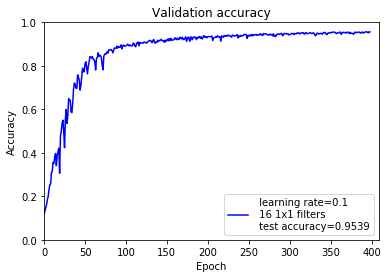

In [3]:
#plot learning curve
import matplotlib.pyplot as plt

def plot(accuracy,max_epochs):
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Validation accuracy')
    ax.set_xlim([0, max_epochs+10])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.plot(accuracy, c='b', label=' learning rate=0.1 \n 16 1x1 filters\n test accuracy={:.4f}'.format(test_error['accuracy']))
    ax.legend(loc='lower right')
    fig.canvas.draw()
    
accuracy = []

for entry in learning_curve:
    accuracy.append(entry['accuracy'])
plot(accuracy,len(learning_curve))
    